Loading dataset...
Dataset loaded. Shape: (30866, 5)
   file_id                                         image_path  \
0    55497  dataset/images/lab/abies_concolor/ny1157-01-1.jpg   
1    55498  dataset/images/lab/abies_concolor/ny1157-01-2.jpg   
2    55499  dataset/images/lab/abies_concolor/ny1157-01-3.jpg   
3    55500  dataset/images/lab/abies_concolor/ny1157-01-4.jpg   
4    55501  dataset/images/lab/abies_concolor/ny1157-02-1.jpg   

                                      segmented_path         species source  
0  dataset/segmented/lab/abies_concolor/ny1157-01...  Abies concolor    lab  
1  dataset/segmented/lab/abies_concolor/ny1157-01...  Abies concolor    lab  
2  dataset/segmented/lab/abies_concolor/ny1157-01...  Abies concolor    lab  
3  dataset/segmented/lab/abies_concolor/ny1157-01...  Abies concolor    lab  
4  dataset/segmented/lab/abies_concolor/ny1157-02...  Abies concolor    lab  
Training set size: 24692, Test set size: 6174
Found 24692 validated image filenames belo

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


772/772 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - accuracy: 0.0410 - loss: 5.0702 - val_accuracy: 0.2593 - val_loss: 3.4536
Epoch 2/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.2330 - loss: 3.4181 - val_accuracy: 0.4150 - val_loss: 2.6339
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 781s 1s/step - accuracy: 0.3522 - loss: 2.7432 - val_accuracy: 0.5076 - val_loss: 2.1878
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.4309 - loss: 2.3410 - val_accuracy: 0.5585 - val_loss: 1.9182
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 788s 1s/step - accuracy: 0.4916 - loss: 2.0663 - val_accuracy: 0.6061 - val_loss: 1.7092
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 780s 1s/step - accuracy: 0.5319 - loss: 1.8802 - val_accuracy: 0.6396 - val_loss: 1.5621
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.5672 - loss: 1.7164 - val_accuracy: 0.6626 - val_loss: 1.4490
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 816s 1s/step - accuracy: 0.5930 - loss: 1.6115 - val_accuracy: 0.681

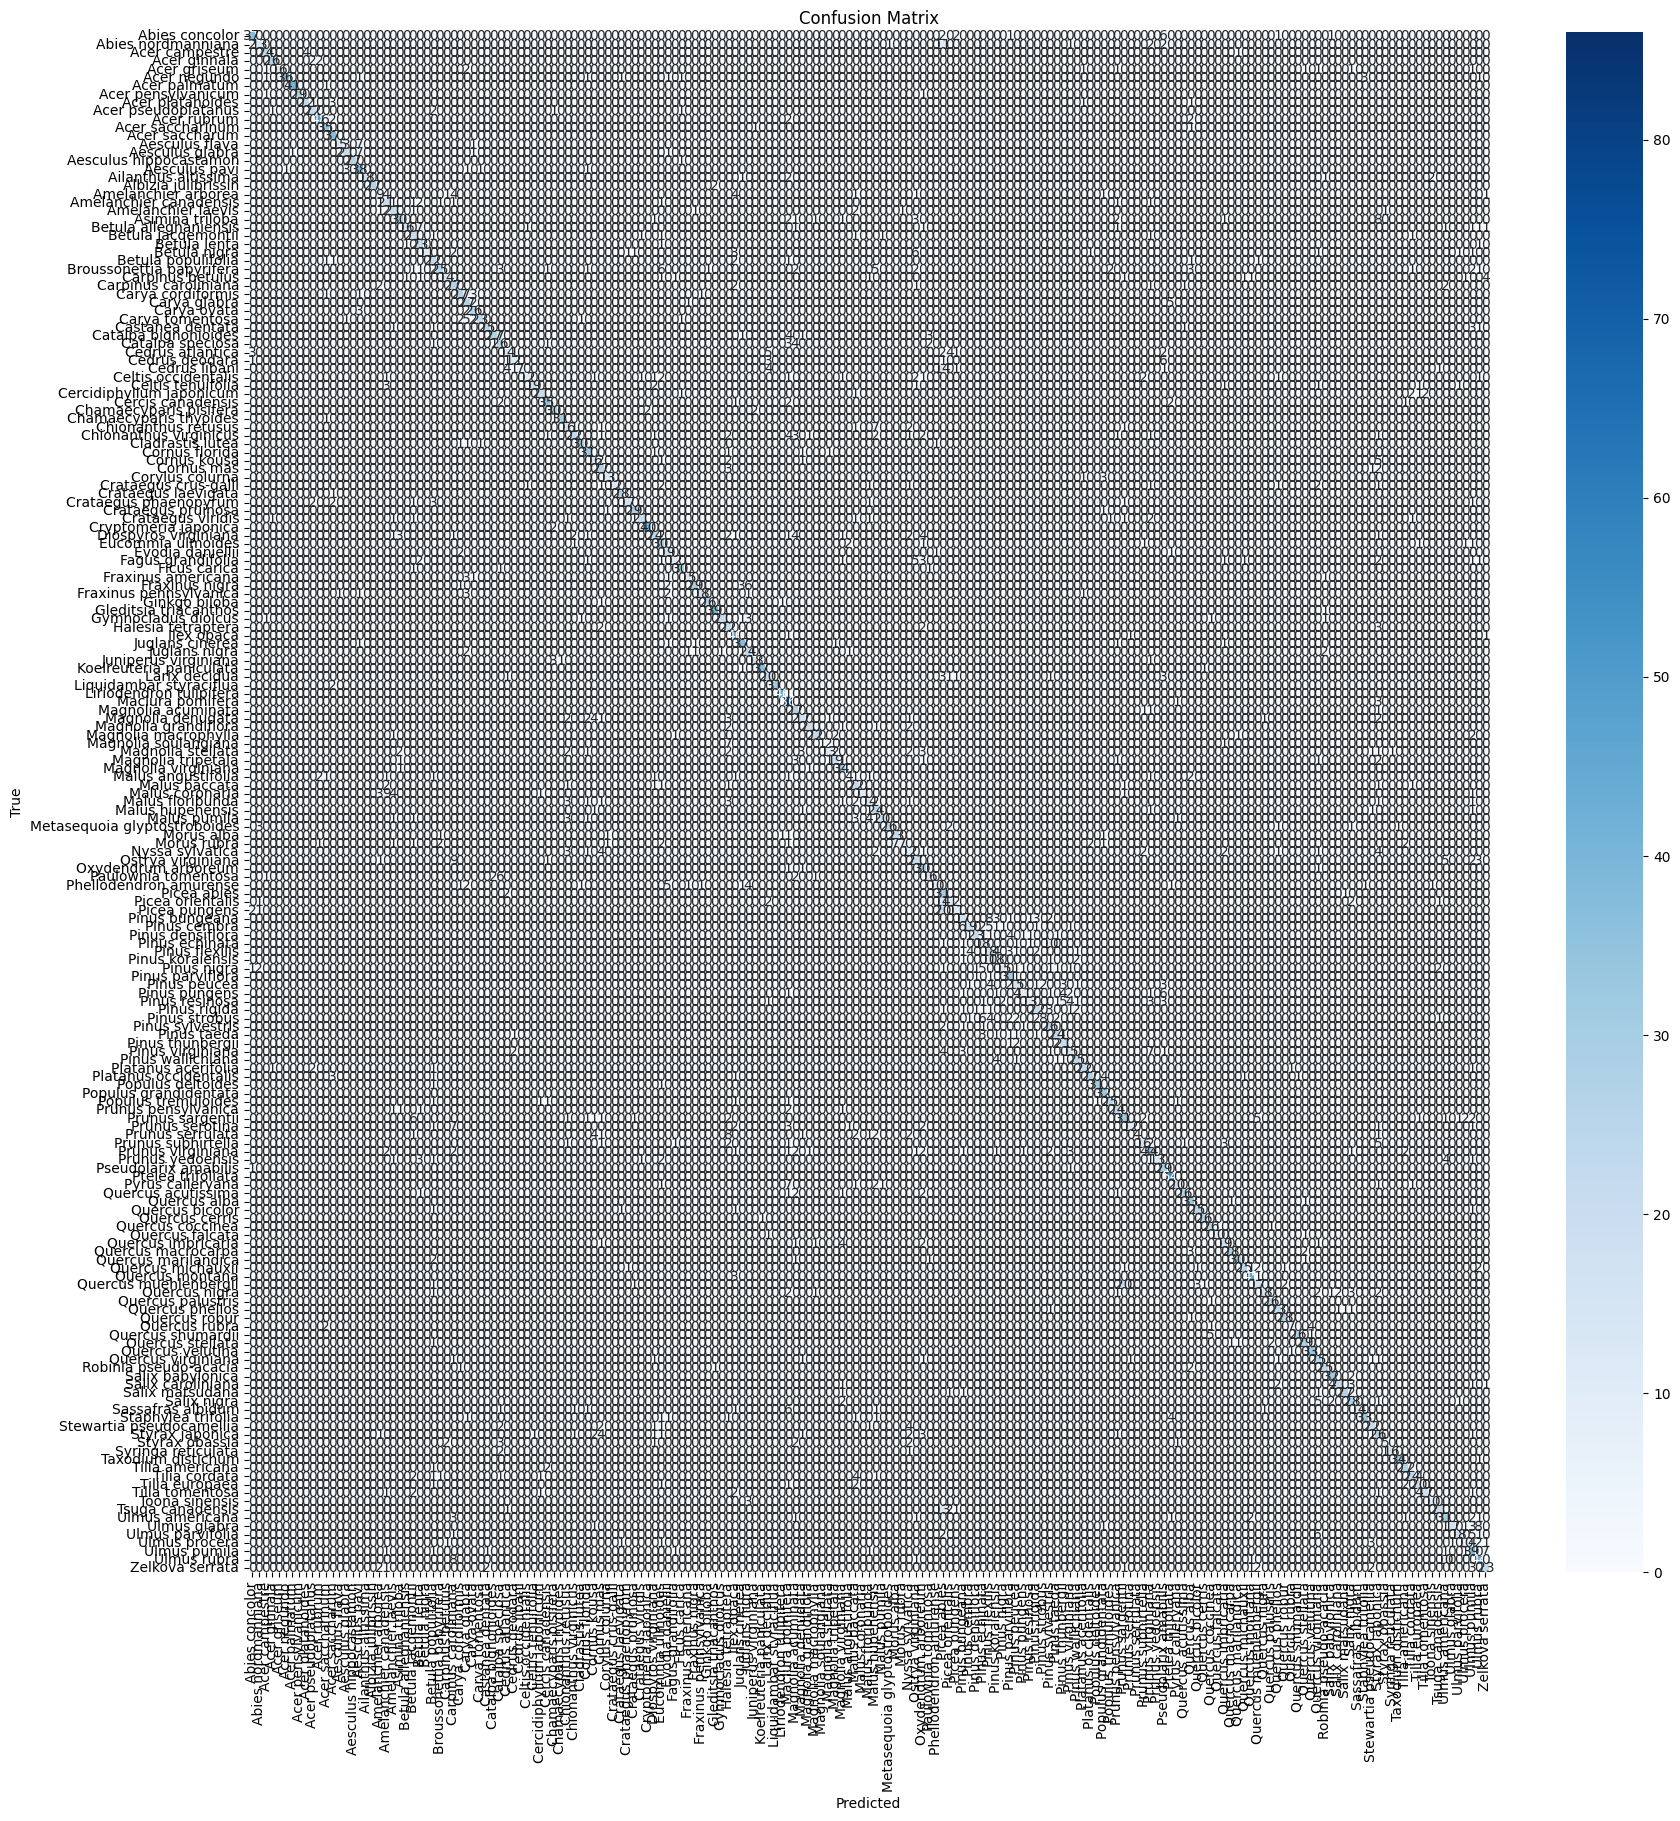

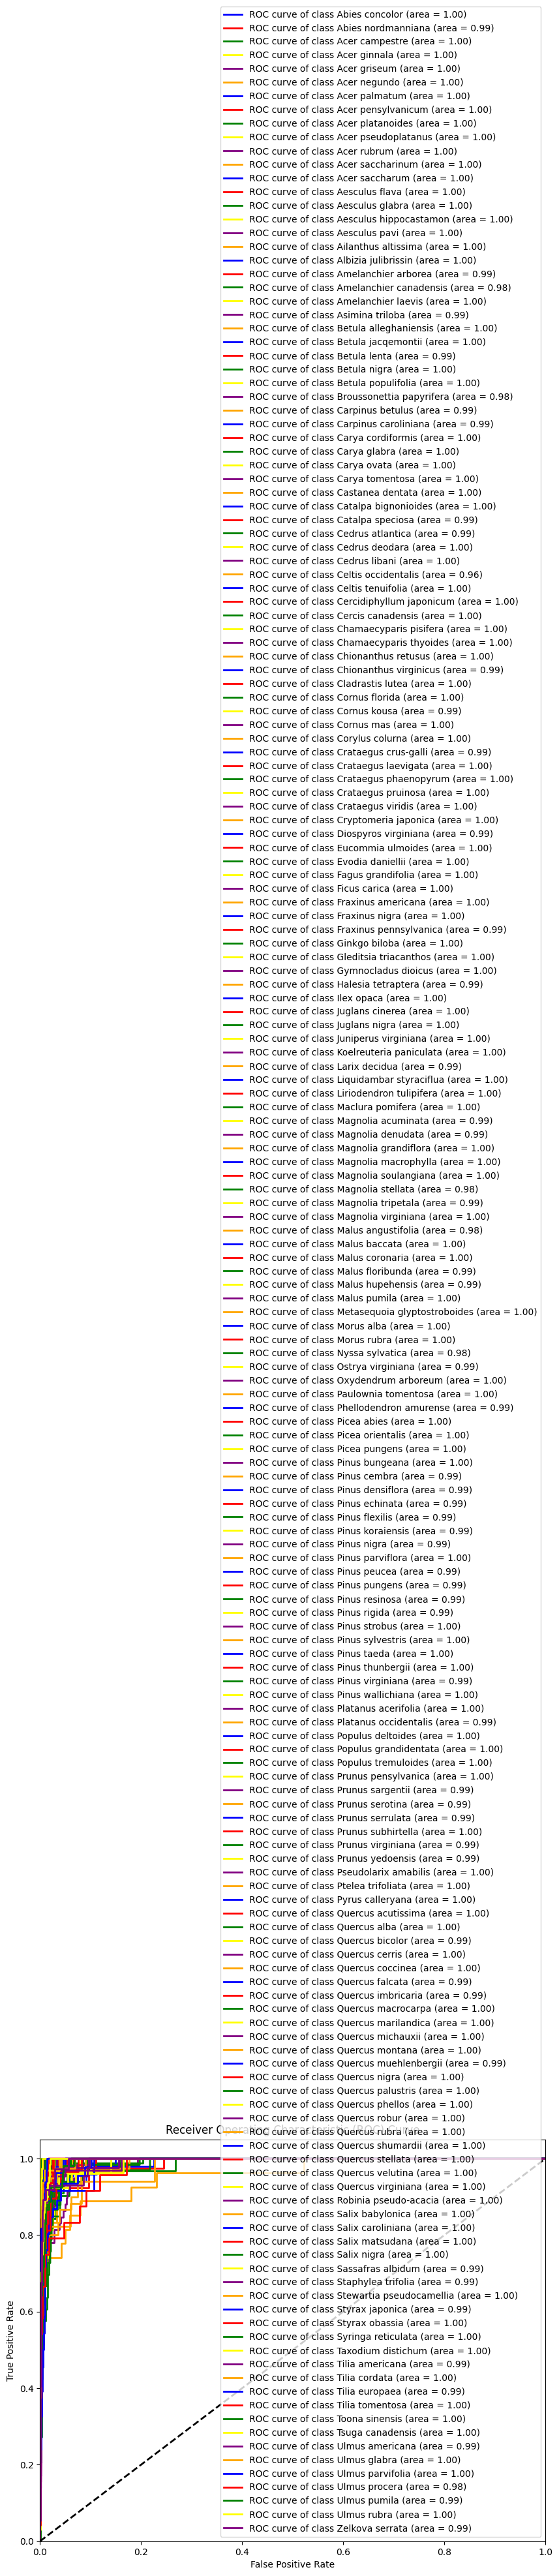

All tasks are done, you may begin new tasks.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from PIL import Image
from tqdm.notebook import tqdm
import gc

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
BASE_PATH = "/kaggle/input/leafsnap-dataset/leafsnap-dataset"
CSV_PATH = os.path.join(BASE_PATH, "leafsnap-dataset-images.txt")
MODEL_SAVE_PATH = 'leaf_model.h5'

IMG_WIDTH = 224
IMG_HEIGHT = 224

# Load and preprocess data
def load_data(csv_path):
    df = pd.read_csv(csv_path, delimiter='\t')
    return df

print("Loading dataset...")
df = load_data(CSV_PATH)
print("Dataset loaded. Shape:", df.shape)
print(df.head())

# Filter out segmented images - only keep 'field' and 'lab' images
df = df[~df['image_path'].str.contains('segmented')]

# Adjust image path to have the full path to the images
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(BASE_PATH, x))

# Encode species labels
label_encoder = LabelEncoder()
df['species_encoded'] = label_encoder.fit_transform(df['species'])
num_classes = len(label_encoder.classes_)

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['species_encoded'], random_state=42)
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

# Data Augmentation and Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='species',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='sparse',
    seed=42,
    interpolation='lanczos'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='species',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    seed=42,
    interpolation='lanczos'
)
gc.collect()

# Transfer Learning Model - MobileNetV2
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False # Freeze the base model

global_average_layer = GlobalAveragePooling2D()
dropout_layer = Dropout(0.3)
prediction_layer = Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

initial_epochs = 10 # Reduced epochs
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Save the Model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# ---------------------------------------------------------------------------------
# Evaluation and Metrics
# ---------------------------------------------------------------------------------

# 1. Evaluate the model
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 2. Generate predictions
print("Generating predictions...")
y_probabilities = model.predict(test_generator)
y_pred = np.argmax(y_probabilities, axis=1)
y_true = test_generator.classes
class_names = list(train_generator.class_indices.keys())

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

gc.collect()

# ---------------------------------------------------------------------------------
# ROC Curve and AUC (for multi-class, needs binarization)
# ---------------------------------------------------------------------------------
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print ("All tasks are done, you may begin new tasks.")